In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from IPython import display
import scipy.signal

In [2]:
sys.path.append('../pythonWrapper/')
import EAProjectorWrapper

sys.path.append('../FileOps/')
import PatchSample
import FileIO

sys.path.append('../Autoencoders/')
import SSAE
import AEDenoising

In [3]:
dataPath = '/home/data1/dufan/lowdoseCTsets/L291/'
prj = EAProjectorWrapper.fan3D()
prj.FromFile(os.path.join(dataPath, 'param.txt'))

with open(os.path.join(dataPath, 'quarter.raw'), 'rb') as f:
    sino = np.fromfile(f, dtype=np.float32)
    f.close()
sino = sino.reshape([prj.nv, prj.rotview, prj.nu])

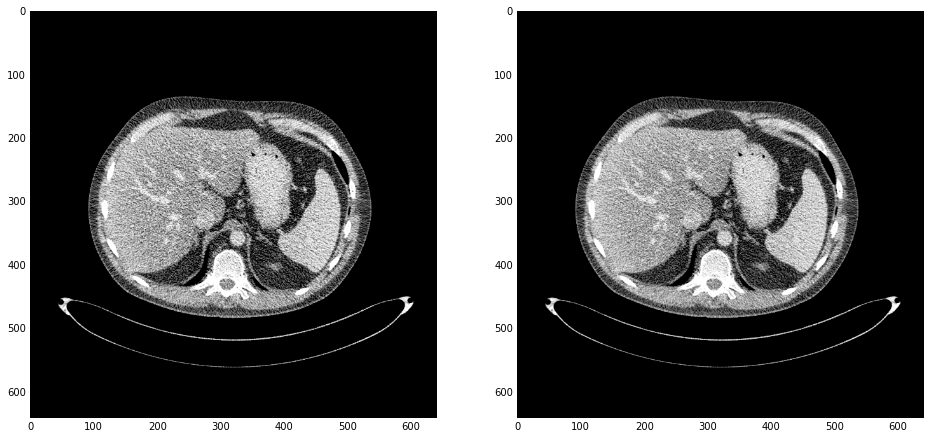

In [4]:
img0 = np.fromfile('../recon/L291/fbp.raw',  dtype=np.float32)
img0 = (img0 + 1000) / 1000 * 0.01937
img0 = np.reshape(img0, [-1, 640,640])

imgRef = np.copy(img0)
for i in range(1, imgRef.shape[0]-1):
    imgRef[i,...] = np.mean(img0[i-1:i+2,...], axis=0)
imgRef[0,...] = np.mean(img0[0:3,...], axis=0)
imgRef[-1,...] = np.mean(img0[-3:,...], axis=0)

plt.figure(figsize=[16,8])
plt.subplot(121); plt.imshow(img0[img0.shape[0]/2,...] / 0.01937 * 1000 - 1000, 'Greys_r', vmin=-160, vmax=240)
plt.subplot(122); plt.imshow(imgRef[imgRef.shape[0]/2,...] / 0.01937 * 1000 - 1000, 'Greys_r', vmin=-160, vmax=240)


In [8]:
def SAEReconSQS(sino, img0, prj, ae, sess_z, sess_xy, strides = None, 
               nIter = 50, hyper=0, subStepSize=0.1, nSteps=1, gamma = 0.5, batchsize=1000, device=3):
    print 'Intialization workers...', 
    prj.SetWorker(0)
    prj.Setup(device)
    print 'Done'
    
    print 'Initialization SQS...',
    weights, data_norm, err = prj.SQSGetWeights(sino)
    prj.SQSInit(weights)
    print 'Done'
    
    print 'Loading projections...',
    prj.SyncPrjFromCPU(sino)
    print 'Done'
        
    total_cfs = list()
    ae_cfs = list()
    x = np.copy(img0)
    z = np.copy(x)
    for iIter in range(nIter):
        print 'Iteration %d'%iIter
        print 'Loading Image...',
        prj.TouchWorker()
        prj.SyncImgFromCPU(x)
        print 'Done'
        
        print 'SAE SQS...',
        axis = np.random.randint(0, 3)
        if axis == 0:
            sess = sess_z
        else:
            sess = sess_xy
        print 'axis = %d'%axis
        x_input = x / 0.01937 * 2 - 2
        ae_diff, ae_norm, cf_ae = AEDenoising.SAEDenoisingSQS3D(x_input, ae, sess, strides, batchsize, 
                                                                subStepSize, nSteps, axis)
        ae_diff = ae_diff / 2 * 0.01937
        cf_ae = cf_ae / 2 / 2 * 0.01937 * 0.01937
        print 'Done'
        
        print 'Data SQS...',
        prj.TouchWorker()
        data_diff, cf_prj = prj.SQSData()
        print 'Done'
        
        print 'Update and momentunm (CPU)...',
        x_new = z - (data_diff + 2 * hyper * ae_diff) / (data_norm + 2 * hyper * ae_norm)
        z = x_new + gamma * (x_new - x)
        x = np.copy(x_new)
        print 'Done'
        
        print 'Rendering...'
        cf = cf_prj + hyper * cf_ae
        total_cfs.append(cf)
        ae_cfs.append(cf_ae)
        
        display.clear_output()
        print 'CF=(%f, %f, %f)'%(cf, cf_prj, cf_ae)
        plt.figure(figsize=[16,8])
        plt.subplot(121); plt.imshow(x[x.shape[0]/2,:,:].squeeze() / 0.01937 * 1000 - 1000, 
                                     'Greys_r', vmin=-160, vmax=240); plt.title('Image at %d'%iIter)
        plt.subplot(222); plt.imshow(x[:,x.shape[1]/2,:].squeeze() / 0.01937 * 1000 - 1000, 
                                     'Greys_r', vmin=-160, vmax=240); 
        plt.subplot(224); plt.imshow(x[:,:,x.shape[2]/2].squeeze() / 0.01937 * 1000 - 1000, 
                                     'Greys_r', vmin=-160, vmax=240); 
        plt.show()
    
    print 'Releasing resources...',
    prj.SQSDestroy()
    prj.DestroyAllWorkers()
    print 'Done'
    
    return x, total_cfs, ae_cfs

In [6]:
tf.reset_default_graph()
ae = SSAE.StackedSparseAutoEncoder(imgshape=[16,16,1], nFeatures=[1024,1024,1024], sparsity=[100,100,100], mode=0)
ae.BuildStackedAutoEncoder(scope='SSAE')
ae.BuildGradientsWRTInput(scope='SSAE')
sess_z = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list='2', 
                                                                  per_process_gpu_memory_fraction=0.45)))
sess_xy = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list='2', 
                                                                  per_process_gpu_memory_fraction=0.45)))
loader = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SSAE'))
loader.restore(sess_z, '../train/KSAE/16x16-xy/k-100-wd-0.1-f-1024-1024-1024/49')
loader.restore(sess_xy, '../train/KSAE/16x16-yz-xz/k-100-wd-0.1-f-1024-1024-1024/49')

CF=(237.578115, 228.313385, 1.852946)


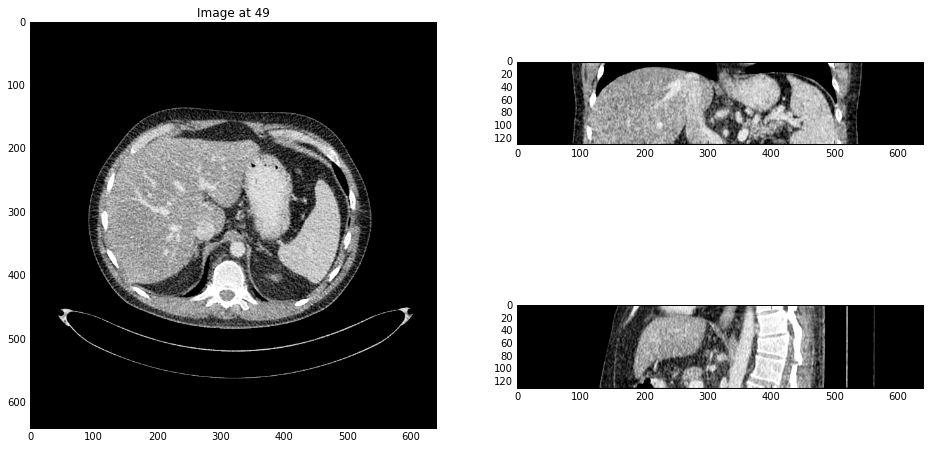

Releasing resources... Done


In [9]:
res = SAEReconSQS(sino, imgRef, prj, ae, sess_z, sess_xy, nIter=50, hyper=5, subStepSize=0.1, nSteps=1, device=3)